Starting FOV calculation with the final rescue algorithm (V7)...
[INFO] sfov table saved to: /Users/yanxing.chen/SafeDrive25SS/Laptimeoptimization/Monza_sfov_V7_calculated.csv

Calculation complete. Please check the generated CSV file and the plot.


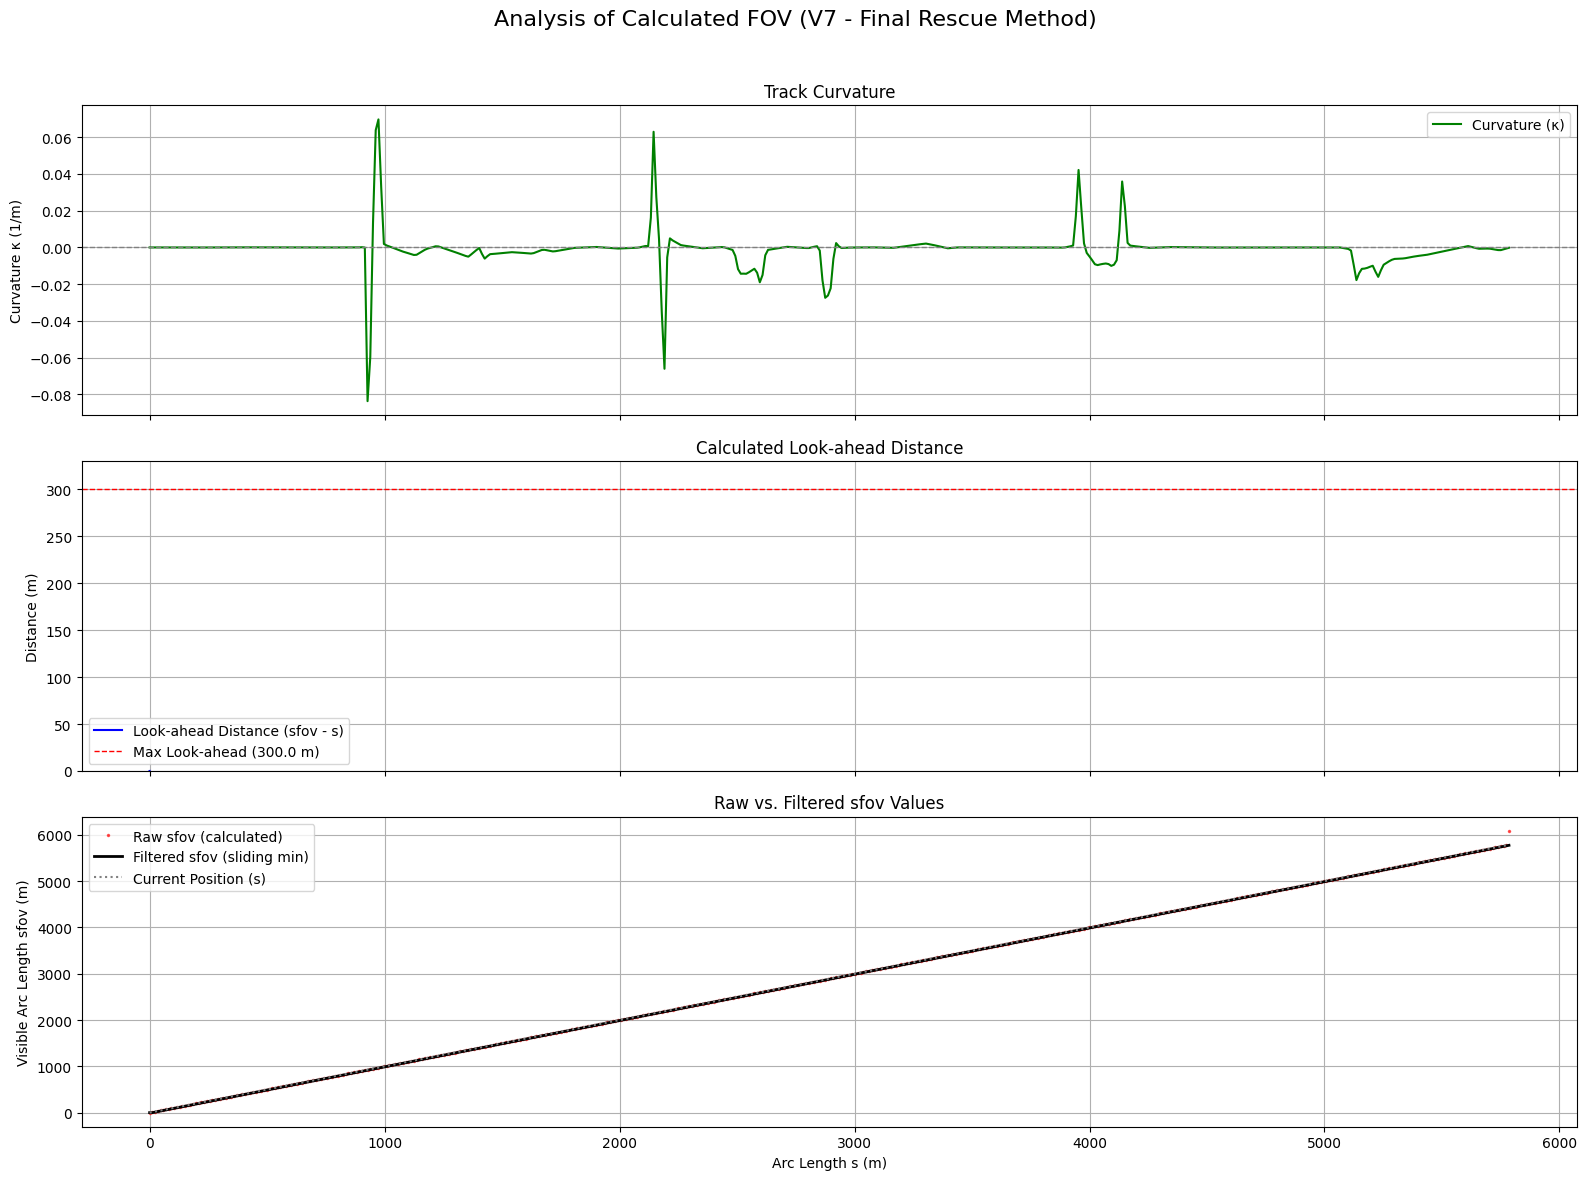

In [10]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd
from typing import Tuple
import os

# ======================================================================
# =================== PART 1: DATA LOADING AND SPLINE ==================
# ======================================================================

# 1. set file path
file_path = "../Laptimeoptimization/Monza.csv"

# 2. read csv file
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    print("Please make sure the CSV file is in the correct directory.")
    exit()

# 3. read the columns
if '# x_m' in df.columns:
    x_col, y_col, w_r_col, w_l_col = '# x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m'
else:
    x_col, y_col, w_r_col, w_l_col = 'x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m'

x = df[x_col].values
y = df[y_col].values
w_left = df[w_l_col].values
w_right = df[w_r_col].values

# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max = s[-1]

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)
dx_ds = x_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)


# ======================================================================
# =========== PART 2: THE FINAL, ROBUST FOV CALCULATION (V7) ===========
# ======================================================================

# --- Parameters tuned for robustness ---
CURV_MIN      = 0
DENSE_STEP    = 0.5
DELTA_S       = 300.0
SLIDING_WIN   = 30

def build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig):
    """Return dense left/right boundary samples."""
    xc = spline_x(s_dense)
    yc = spline_y(s_dense)
    dx = spline_x.derivative(1)(s_dense)
    dy = spline_y.derivative(1)(s_dense)
    norm_t = np.hypot(dx, dy)
    tx, ty = dx / norm_t, dy / norm_t
    nx, ny = -ty, tx
    w_left_d  = np.interp(s_dense, s_orig, w_left)
    w_right_d = np.interp(s_dense, s_orig, w_right)
    xl = xc + nx * w_left_d
    yl = yc + ny * w_left_d
    xr = xc - nx * w_right_d
    yr = yc - ny * w_right_d
    return (xl, yl), (xr, yr)

# ======================================================================
# ================== V8 - THE DEFINITIVE FIX ===========================
# ======================================================================

# ======================================================================
# ================== V9 - FOOLPROOF ANGLE CALCULATION ==================
# ======================================================================

def compute_fov_all_final_rescue(spline_x, spline_y,
                                 w_left: np.ndarray, w_right: np.ndarray,
                                 s_query: np.ndarray, s_orig: np.ndarray, s_max_val: float,
                                 delta_s: float = DELTA_S,
                                 step: float = DENSE_STEP):
    """
    V9: Replaces the cross/dot product angle calculation with a foolproof,
    explicit angle difference calculation to eliminate any possible ambiguity.
    """
    s_dense = np.arange(0, s_max_val + step, step)
    (xl, yl), (xr, yr) = build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig)
    sfov_raw = np.empty_like(s_query)
    
    dx_ds_func = spline_x.derivative(1)
    dy_ds_func = spline_y.derivative(1)
    d2x_ds2_func = spline_x.derivative(2)
    d2y_ds2_func = spline_y.derivative(2)

    for k, s0 in enumerate(s_query):
        kappa_now = (dx_ds_func(s0) * d2y_ds2_func(s0) - dy_ds_func(s0) * d2x_ds2_func(s0))

        if abs(kappa_now) < CURV_MIN:
            sfov_raw[k] = s0 + delta_s
            continue

        s0_pos = np.array([spline_x(s0), spline_y(s0)])
        raw_dir_vec = np.array([dx_ds_func(s0), dy_ds_func(s0)])
        dir_vec = raw_dir_vec / np.linalg.norm(raw_dir_vec)

        # --- EXPLICIT ANGLE of the direction vector ---
        angle_dir = np.arctan2(dir_vec[1], dir_vec[0])
        # -----------------------------------------------

        idx0 = np.searchsorted(s_dense, s0)
        idx_w = np.searchsorted(s_dense, s0 + delta_s, side='right')
        
        s_win = s_dense[idx0:idx_w]
        xl_win, yl_win = xl[idx0:idx_w], yl[idx0:idx_w]
        xr_win, yr_win = xr[idx0:idx_w], yr[idx0:idx_w]

        s_tan_L, s_tan_R = np.inf, np.inf

        # --- Find tangent on the LEFT boundary ---
        if len(xl_win) > 1:
            Vx_L = xl_win - s0_pos[0]
            Vy_L = yl_win - s0_pos[1]
            mask_L = (Vx_L**2 + Vy_L**2) > 4.0
            if np.any(mask_L):
                angle_V_L = np.arctan2(Vy_L[mask_L], Vx_L[mask_L])
                theta_L = angle_V_L - angle_dir
                # Normalize angles to [-pi, pi]
                theta_L = (theta_L + np.pi) % (2 * np.pi) - np.pi
                
                idx_ext_L = np.argmax(theta_L)
                s_tan_L = s_win[mask_L][idx_ext_L]

        # --- Find tangent on the RIGHT boundary ---
        if len(xr_win) > 1:
            Vx_R = xr_win - s0_pos[0]
            Vy_R = yr_win - s0_pos[1]
            mask_R = (Vx_R**2 + Vy_R**2) > 4.0
            if np.any(mask_R):
                angle_V_R = np.arctan2(Vy_R[mask_R], Vx_R[mask_R])
                theta_R = angle_V_R - angle_dir
                # Normalize angles to [-pi, pi]
                theta_R = (theta_R + np.pi) % (2 * np.pi) - np.pi

                idx_ext_R = np.argmin(theta_R)
                s_tan_R = s_win[mask_R][idx_ext_R]

        sfov_raw[k] = min(s_tan_L, s_tan_R, s0 + delta_s)

    win_samples = int(SLIDING_WIN / (s_query[1] - s_query[0])) if len(s_query) > 1 else 1
    sfov_series = pd.Series(sfov_raw)
    sfov_filt = sfov_series.rolling(window=win_samples, min_periods=1, center=True).min().to_numpy()
    
    return sfov_raw, sfov_filt

# ======================================================================
# ================= PART 3: EXECUTION AND SAVING =======================
# ======================================================================

s_query = np.linspace(0, s_max, 500)
print("Starting FOV calculation with the final rescue algorithm (V7)...")

sfov_raw_vals, sfov_filtered_vals = compute_fov_all_final_rescue(
    x_spline, y_spline, w_left, w_right, s_query, s, s_max,
    delta_s=DELTA_S, step=DENSE_STEP
)

sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_filtered_vals)
_ = save_sfov_csv(s_query, sfov_filtered_vals, file_path, out_name="Monza_sfov_V7_calculated.csv")
print("\nCalculation complete. Please check the generated CSV file and the plot.")

# ======================================================================
# ===================== PART 4: VISUALIZATION ==========================
# ======================================================================

look_ahead_dist = sfov_filtered_vals - s_query
kappa_query = (dx_ds(s_query) * d2y_ds2(s_query) - dy_ds(s_query) * d2x_ds2(s_query))

fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Analysis of Calculated FOV (V7 - Final Rescue Method)', fontsize=16)

axs[0].plot(s_query, kappa_query, color='green', label='Curvature (κ)')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_ylabel("Curvature κ (1/m)")
axs[0].set_title("Track Curvature")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(s_query, look_ahead_dist, color='blue', label='Look-ahead Distance (sfov - s)')
axs[1].axhline(DELTA_S, color='red', linestyle='--', linewidth=1, label=f'Max Look-ahead ({DELTA_S} m)')
axs[1].set_ylabel("Distance (m)")
axs[1].set_title("Calculated Look-ahead Distance")
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(0, DELTA_S * 1.1)

axs[2].plot(s_query, sfov_raw_vals, 'r.', markersize=3, alpha=0.6, label='Raw sfov (calculated)')
axs[2].plot(s_query, sfov_filtered_vals, 'k-', linewidth=2, label='Filtered sfov (sliding min)')
axs[2].plot(s_query, s_query, ':', color='gray', linewidth=1.5, label='Current Position (s)')
axs[2].set_xlabel("Arc Length s (m)")
axs[2].set_ylabel("Visible Arc Length sfov (m)")
axs[2].set_title("Raw vs. Filtered sfov Values")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()